In [42]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt

import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt

def flatten_metrics(metrics):
    flattened = {}
    flattened["CoLA"] = {
        "metric": "mcc",
        "mean": metrics['CoLA']['mcc'][0],
        "stdv": metrics['CoLA']['mcc'][1]
    }
    flattened["MNLI-mm"] = {
        "metric": "acc",
        "mean": metrics["MNLI"]["mnli-mm_acc"][0],
        "stdv": metrics["MNLI"]["mnli-mm_acc"][1]
    }
    
    flattened["MNLI"] = {
        "metric": "acc",
        "mean": metrics["MNLI"]["mnli_acc"][0],
        "stdv": metrics["MNLI"]["mnli_acc"][1]
    }
    flattened["MNLI-mm"] = {
        "metric": "acc",
        "mean": metrics["MNLI"]["mnli-mm_acc"][0],
        "stdv": metrics["MNLI"]["mnli-mm_acc"][1]
    }
    flattened["MRPC"] = {
        "metric": "acc",
        "mean": metrics["MRPC"]["acc"][0],
        "stdv": metrics["MRPC"]["acc"][1]
    }
    flattened["QNLI"] = {
        "metric": "acc",
        "mean": metrics["QNLI"]["acc"][0],
        "stdv": metrics["QNLI"]["acc"][1]
    }
    flattened["QQP"] = {
        "metric": "acc",
        "mean": metrics["QQP"]["acc"][0],
        "stdv": metrics["QQP"]["acc"][1]
    }
    flattened["RTE"] = {
        "metric": "acc",
        "mean": metrics["RTE"]["acc"][0],
        "stdv": metrics["RTE"]["acc"][1]
    }
    flattened["SST-2"] = {
        "metric": "acc",
        "mean": metrics["SST-2"]["acc"][0],
        "stdv": metrics["SST-2"]["acc"][1]
    }
    flattened["STS-B"] = {
        "metric": "corr",
        "mean": metrics["STS-B"]["pearson"][0],
        "stdv": metrics["STS-B"]["pearson"][1]
    }
    flattened["WNLI"] = {
        "metric": "acc",
        "mean": metrics["WNLI"]["acc"][0],
        "stdv": metrics["WNLI"]["acc"][1]
    }
    return flattened

def plot_task_metrics(experiment_metrics, task, title):
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in experiment_metrics]
    
    experiment_names = [e_m[0] for e_m in experiment_metrics]
    metrics_data = [e_m[1] for e_m in experiment_metrics]
    
    x_pos = np.arange(len(experiment_names))
    means = [m[task]["mean"] for m in metrics_data]
    errors = [m[task]["stdv"] for m in metrics_data]
    fig, ax = plt.subplots(figsize=(9,9))
    ax.bar(x_pos, means, yerr=errors, align='center', color="#ea593f")
    ax.set_ylabel(metrics_data[0][task]["metric"])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(experiment_names, rotation='vertical')
    ax.set_title(f"{title} : {task}")
    ax.yaxis.grid(True)
    #plt.tight_layout()
    plt.show()

def plot_all_task_metrics(metrics, title):
    for name in metrics[0][1].keys():
        plot_task_metrics(analyzed_metrics, name, title)


def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title=''):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=plt.cm.OrRd)

    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path)



In [29]:
experiments_path = pathlib.Path("../masks_results")
def load_head_data():
    head_data = {}
    for task_dir in experiments_path.iterdir():
        head_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            head_mask = np.load(seed_dir / "head_mask.npy")
            head_importance = np.load(seed_dir / "head_importance.npy")
            head_data[task_dir.stem][seed_dir.stem] = {
                "head_mask": head_mask,
                "head_importance": head_importance
            }
    return head_data
head_data = load_head_data()


In [30]:
def load_mlp_data():
    mlp_data = {}
    experiments_path = pathlib.Path("../mlp_masks_results")
    for task_dir in experiments_path.iterdir():
        mlp_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mlp_mask = np.load(seed_dir / "mlp_mask.npy")
            mlp_importance = np.load(seed_dir / "mlp_importance.npy")
            mlp_data[task_dir.stem][seed_dir.stem] = {
                "mlp_mask": mlp_mask,
                "mlp_importance": mlp_importance
            }
    return mlp_data
mlp_data = load_mlp_data()



# Task wise overlap % of pruned masks for each seed

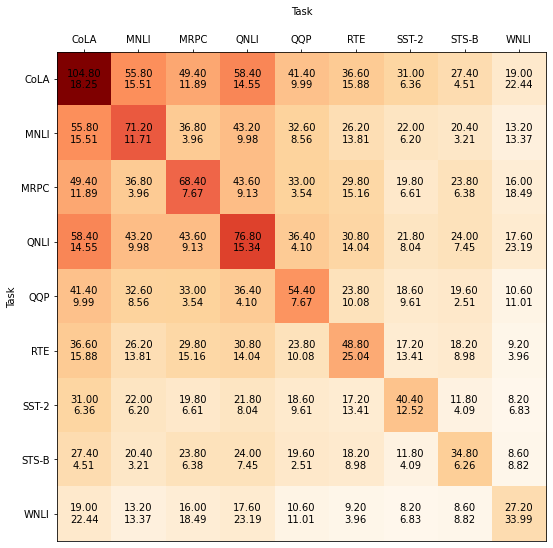

In [31]:
def task_overlap_attention_heads():
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    results = np.zeros((len(seeds), len(tasks), len(tasks)))
    for seed_idx, seed in enumerate(seeds):
        for task_1_idx, task_1 in enumerate(tasks):
            for task_2_idx, task_2 in enumerate(tasks):
                common_heads = np.sum(head_data[task_1][seed]["head_mask"] * head_data[task_2][seed]["head_mask"])
                results[seed_idx][task_1_idx][task_2_idx] = common_heads
                
    mean_shared_heads = np.mean(results, axis=0)
    std_shared_heads = np.std(results, axis=0, ddof=1)
    plot_matrix(mean_shared_heads, std_shared_heads, tasks, tasks, "task_v_task_heads.pdf", "Task", "Task")
task_overlap_attention_heads()

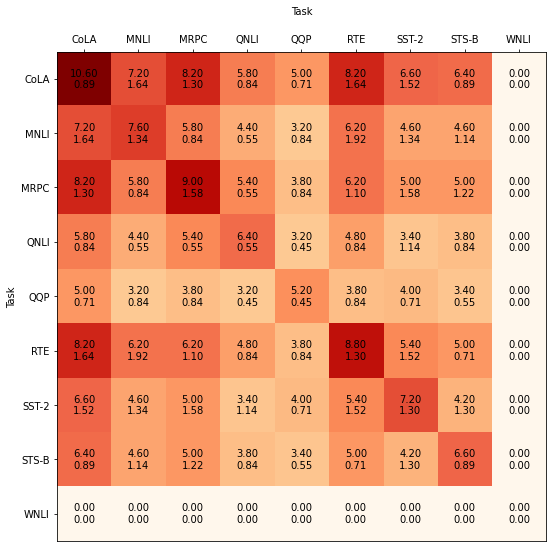

In [32]:
def task_overlap_mlps():
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    results = np.zeros((len(seeds), len(tasks), len(tasks)))
    for seed_idx, seed in enumerate(seeds):
        for task_1_idx, task_1 in enumerate(tasks):
            for task_2_idx, task_2 in enumerate(tasks):
                common_mlps = np.sum(mlp_data[task_1][seed]["mlp_mask"] * mlp_data[task_2][seed]["mlp_mask"])
                results[seed_idx][task_1_idx][task_2_idx] = common_mlps
                
    mean_shared_mlps = np.mean(results, axis=0)
    std_shared_mlps = np.std(results, axis=0, ddof=1)
    std_shared_mlps = np.std(results, axis=0, ddof=1)
    plot_matrix(mean_shared_mlps, std_shared_mlps, tasks, tasks, "task_v_task_mlps.pdf", "Task", "Task")
task_overlap_mlps()

# Components heatmap

## Heads

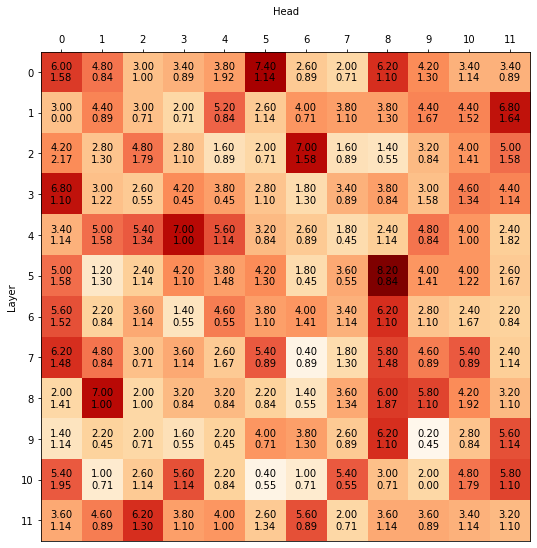

In [33]:

def show_heads_heatmap():
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    pruned_head_results = np.zeros((len(seeds), 12, 12)) # 12 layers with 12 heads each
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_head_results[seed_idx] += head_data[task][seed]["head_mask"]
    mean_pruned_heads = np.mean(pruned_head_results, axis=0)
    std_pruned_heads = np.std(pruned_head_results, axis=0, ddof=1)

    plot_matrix(mean_pruned_heads, std_pruned_heads, list(map(str, range(12))), list(map(str, range(12))), "head_heatmap.pdf", "Head", "Layer")
show_heads_heatmap()

## MLP

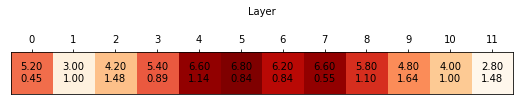

In [34]:
def show_mlps_heatmap():
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    pruned_mlps_results = np.zeros((len(seeds), 1, 12)) # 12 layers
    for task_idx, task in enumerate(tasks):
        for seed_idx, seed in enumerate(seeds):
            pruned_mlps_results[seed_idx] += mlp_data[task][seed]["mlp_mask"]
    mean_pruned_mlps = np.mean(pruned_mlps_results, axis=0)
    std_pruned_mlps = np.std(pruned_mlps_results, axis=0, ddof=1)

    plot_matrix(mean_pruned_mlps, std_pruned_mlps, list(map(str, range(12))), [], "mlp_heatmap.pdf", "Layer", "")

show_mlps_heatmap()

# Performance analysis

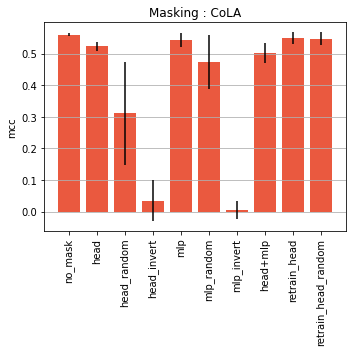

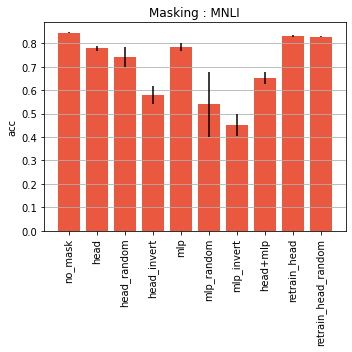

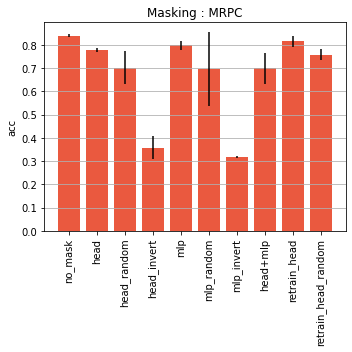

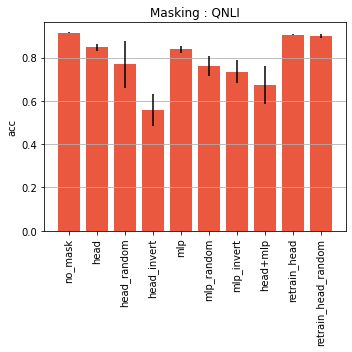

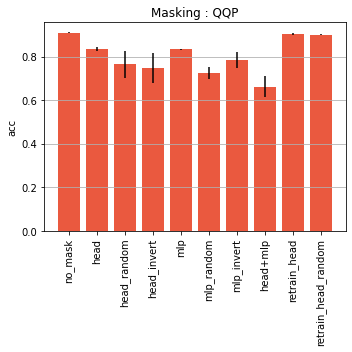

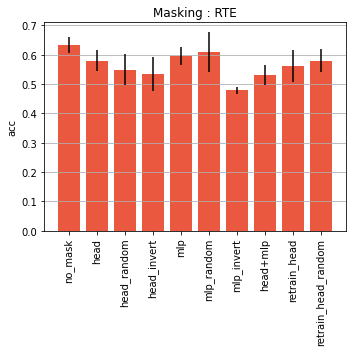

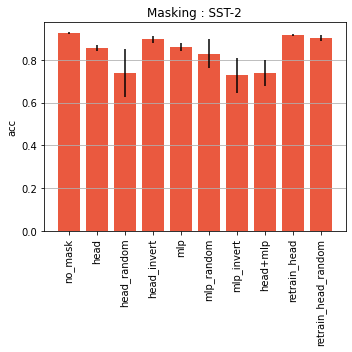

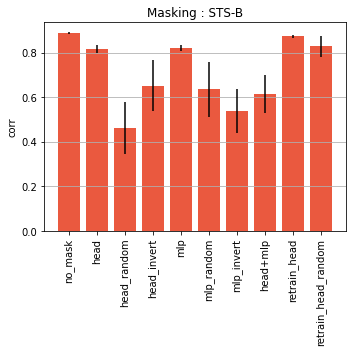

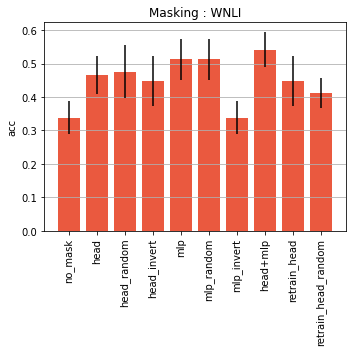

In [44]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
    "no_mask": evaluation_dir / "original_without_any_mask" / "baseline" / "results.json",
    "head": evaluation_dir / "original_with_mask" / "baseline" / "results.json",

    
    "head_random": evaluation_dir / "original_with_mask_random" / "baseline" / "results.json",
    "head_invert": evaluation_dir / "original_with_mask_inverted" / "baseline" / "results.json",
   
    "mlp": evaluation_dir / "original_with_mlp_mask" / "baseline" / "results.json",
    "mlp_random": evaluation_dir / "original_with_mlp_mask_random" / "baseline" / "results.json",
    "mlp_invert": evaluation_dir / "original_with_mlp_mask_invert" / "baseline" / "results.json",
   
    "head+mlp": evaluation_dir / "original_with_mlp_mask_head_mask" / "baseline" / "results.json",

    "retrain_head": evaluation_dir / "retrain_with_head_mask" / "baseline" / "results.json",
    "retrain_head_random": evaluation_dir / "retrain_with_random_head_mask" / "baseline" / "results.json",

}

analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))

def plot_task_metrics(experiment_metrics, task, title):
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in experiment_metrics]
    
    experiment_names = [e_m[0] for e_m in experiment_metrics]
    metrics_data = [e_m[1] for e_m in experiment_metrics]
    
    x_pos = np.arange(len(experiment_names))
    means = [m[task]["mean"] for m in metrics_data]
    errors = [m[task]["stdv"] for m in metrics_data]
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(x_pos, means, yerr=errors, align='center', color="#ea593f")
    ax.set_ylabel(metrics_data[0][task]["metric"])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(experiment_names, rotation='vertical')
    ax.set_title(f"{title} : {task}")
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()


plot_all_task_metrics(analyzed_metrics, "Masking")
